<a href="https://colab.research.google.com/github/Itai1991Ortner/Machine-Learning/blob/main/kickStart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split as split ,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier
from sklearn.mixture import GaussianMixture
from sklearn.utils import resample

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
my_path='/content/drive/MyDrive/kickstart/ks-projects-201801.csv'
df=pd.read_csv(my_path,parse_dates=["deadline","launched"])

In [ ]:
# create a map of features - to understand the content better
def table_info(df):
    print(f"Dataset Shape: {df.shape}")
    first_check = pd.DataFrame(df.dtypes,columns=['dtypes'])
    first_check = first_check.reset_index()
    first_check['Name'] = first_check['index']
    first_check = first_check[['Name','dtypes']]
    first_check['isnull'] = df.isnull().sum().values    
    first_check['num_Uniques'] = df.nunique().values

    return first_check

#present the table above
table_info(df)

Dataset Shape: (378661, 15)


,Name,dtypes,isnull,num_Uniques
0,ID,int64,0,378661
1,name,object,4,375764
2,category,object,0,159
3,main_category,object,0,15
4,currency,object,0,14
5,deadline,datetime64[ns],0,3164
6,goal,float64,0,8353
7,launched,datetime64[ns],0,378089
8,pledged,float64,0,62130
9,state,object,0,6


In [15]:
#base cleaning
df=df.rename(lambda col: col.strip(),axis=1)
df.columns = df.columns.str.replace(' ','_')

df["dates_gap"]=(df["deadline"]-df["launched"]).dt.days
df=df.drop(columns=['ID','name','deadline','launched',"usd_pledged",'goal','usd_goal_real'], axis=1)

# EDA

Text(0.5, 1.0, 'Target options - imbalance Data')

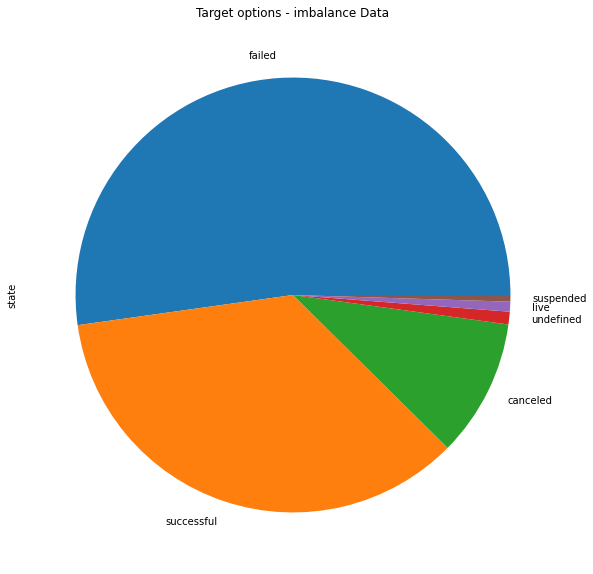

In [ ]:
#target distribution
figure = plt.figure(figsize = (20,10))
df["state"].value_counts().plot.pie()
plt.title('Target options - imbalance Data')

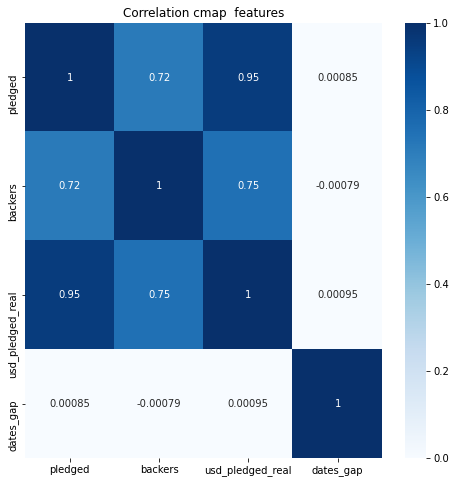

In [30]:
#correlation heatmap plot
plt.figure(figsize=(8,8))
correl=df.corr()
sns.heatmap(correl,annot=True,cmap='Blues')
plt.title('Correlation cmap  features')
plt.show()

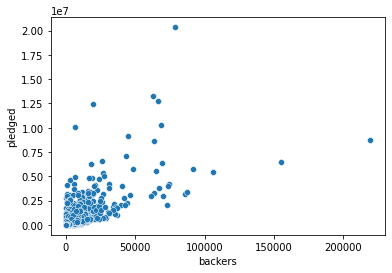

In [31]:
#plotting connection between backers and pledged
sns.scatterplot(data=df, x='backers',y='pledged')

# Preprocessing

In [16]:
#replacing and diminishing number of classes 
df["state"]=df["state"].replace({'canceled':'failed'}).replace({'live':'other'}).replace({'undefined':'other'}).replace({'suspended':'failed'})

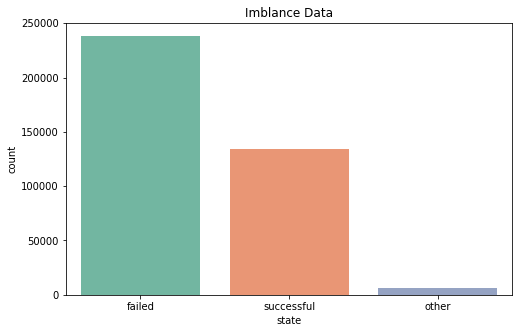

In [ ]:
#presenting the imbalance challange barplot
figure = plt.figure(figsize = (8,5))
sns.countplot(data=df,x='state',palette='Set2')
plt.title('Imblance Data')
plt.show()

In [17]:
#initiating X and y
X=df.drop(columns=["state",'currency','country'])
X_numeric=df.drop(columns=["category","main_category","currency","country","state"])
y=df["state"]

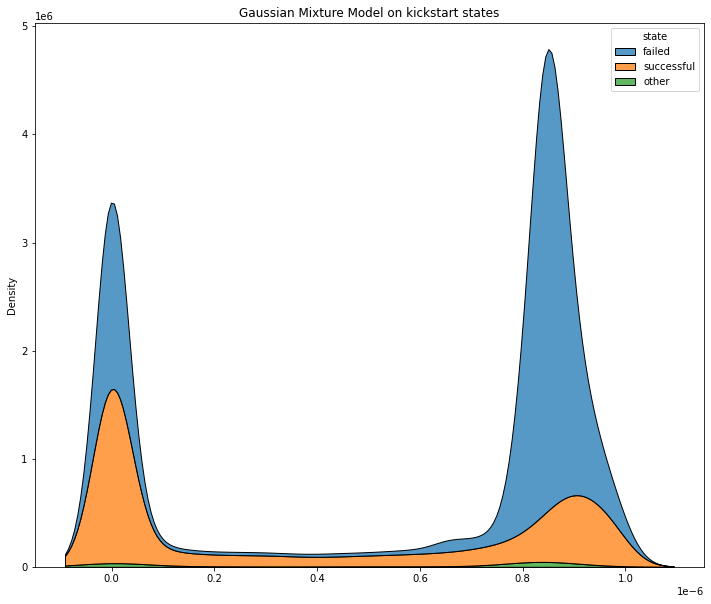

In [ ]:
gmm = GaussianMixture(n_components=2).fit(X_numeric)
samp=gmm.score_samples(X_numeric)
plt.figure(figsize=(12,10))
sns.kdeplot(data=df,x=np.exp(samp),hue="state", fill=True, multiple="stack")
plt.title("Gaussian Mixture Model on kickstart states")
plt.show()

In [18]:
# method that use PCA to remove outliers
def remove_outliers(X,y,X_numeric, n_outliers):
  out_X=X.copy()
  out_y=y.copy()

  pca = PCA(n_components=3)

  pca.fit(X_numeric)
  X_reconstructed = pca.inverse_transform(pca.transform(X_numeric))
  X_reconstructed = pd.DataFrame(X_reconstructed,index=X_numeric.index,columns = X_numeric.columns)
  errors=((X_reconstructed - X_numeric)**2).sum(axis=1)
    
  X_new=pd.concat([out_X,errors.rename("X_reconstructed")],axis=1)
  X_new=X_new.sort_values(ascending=False,by="X_reconstructed")
  X_new=X_new.iloc[:-1*n_outliers,:]
  y_new=out_y.iloc[X_new.index]

  return X_new,y_new


#executing the outlier removal
X,y=remove_outliers(X,y,X_numeric,100)
X

,category,main_category,pledged,backers,usd_pledged_real,dates_gap,X_reconstructed
319002,Publishing,Publishing,0.00,0,0.00,16738,2.790408e+08
2842,Film & Video,Film & Video,0.00,0,0.00,14866,2.200035e+08
48147,Art,Art,0.00,0,0.00,14834,2.190552e+08
94579,Theater,Theater,0.00,0,0.00,14760,2.168702e+08
75397,Film & Video,Film & Video,0.00,0,0.00,14749,2.165464e+08
...,...,...,...,...,...,...,...
59402,Tabletop Games,Games,27127.84,1186,27127.84,33,6.392721e-02
328696,Tabletop Games,Games,154609.99,4451,154609.99,33,6.168709e-02
92333,Design,Design,265397.00,3316,406888.36,34,6.032452e-02
329017,Video Games,Games,39061.02,1652,65722.78,33,6.010816e-02


# Pipeline

In [19]:
#spliting the Data
X_train,X_test,y_train,y_test=split(X,y, test_size=0.3,random_state=1)

In [20]:
#one_hot_encoder transformer
class MyOneHotEncoder(TransformerMixin, BaseEstimator):
    
    def __init__(self):
        self.ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")
    
    def fit(self, X, y=None):
        self.ohe.fit(X[["category","main_category"]])
        return self
    
    def transform(self, X):
        transformed_data = pd.DataFrame(self.ohe.transform(X[["category","main_category"]]))
        numerical_features = X.drop(columns=["category","main_category"], axis=1)
        
        return np.concatenate([numerical_features,transformed_data], axis=1)
    def get_feature_names(self):
        pass

In [21]:
my_ohe = MyOneHotEncoder()
ss     = StandardScaler()

my_Pipeline = Pipeline([("my_ohe", my_ohe), ("my_scaler", ss)])

X_train_scaled=my_Pipeline.fit_transform(X_train)
X_test_scaled=my_Pipeline.transform(X_test)

# Smote

In [22]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [23]:
#dealing with imbalance by oversample the "other" class with SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
oversample = RandomOverSampler(random_state=0)
X_train_smote, y_train = SMOTE().fit_resample(X_train_scaled, y_train)

# Model

In [26]:
my_xgb=XGBClassifier()

learning_rate=[0.05,0.1,0.15,0.2,0.25]
max_depth=[2,3,5,7,10]
n_estimators=[50,100,200]
gamma=[0.0,0.1,0.2,0.3,0.4]
scale_pos_weight=[1,3,5]
max_features=[3,5,7,10]
min_samples_split=[3,5,7,10,20]
subsample=[0.5,0.8,1]


xgb_params={'learning_rate': learning_rate,
            'max_depth': max_depth,
            'n_estimators': n_estimators,
            'gamma': gamma,
            'subsample':subsample,
            'scale_pos_weight': scale_pos_weight,
            'objective' : 'multi:softprob'}


rnd_model=RandomizedSearchCV(my_xgb,xgb_params,n_iter=5,scoring='f1_micro',cv=3,verbose=2)


In [ ]:
rnd_model.fit(X_train_smote,y_train)

In [28]:
y_pred=rnd_model.predict(X_test_scaled)

# Results

In [29]:
cm_f1_micro_weight =  confusion_matrix(y_true=y_test, y_pred=y_pred)
print(cm_f1_micro_weight)
print(classification_report(y_true=y_test, y_pred=y_pred))

[[58885  1924 10618]
 [  604  1121   197]
 [ 3771   239 36210]]
              precision    recall  f1-score   support

      failed       0.93      0.82      0.87     71427
       other       0.34      0.58      0.43      1922
  successful       0.77      0.90      0.83     40220

    accuracy                           0.85    113569
   macro avg       0.68      0.77      0.71    113569
weighted avg       0.86      0.85      0.85    113569



# Another  way to deal with Imbalance data

In [ ]:
# also tried oversampling the data by just multypling the other samples as is - the results of the model were'nt pretty good
def overSampling(df):
  other_samples=df[df['state']=='other']
  df_minority=resample(other_samples,replace=True,n_samples=(len(other_samples)*5))
  df_majority=df[df['state']!='other']
  return pd.concat([df_majority,df_minority])

df=overSampling(df)
#now let's shuffle the data
df = df.sample(frac = 1)